In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
tf.random.set_seed(123)

In [3]:
df = pd.read_csv('LA pm25.csv', parse_dates=['date', 'utc','local'], index_col='utc')
df = df.resample('d').mean()
df = df.interpolate(method='time')
df.head()

,value,mobile,latitude,longitude,url,averaging_time,station,latitude-2,longitude-2,elevation,...,slp,stp,visibility,wind_speed,max_sustained_wind,gust,max_temp,min_temp,precipitation,snow_depth
utc,,,,,,,,,,,,,,,,,,,,,
2020-01-02,11.355556,0.0,34.181976,-118.36304,NaN,1.0,7.228802e+10,34.20056,-118.3575,225.9,...,1012.5,986.8,10.0,4.5,12.0,NaN,68.0,43.0,0.0,0.0
2020-01-03,18.295833,0.0,34.181976,-118.36304,NaN,1.0,7.228802e+10,34.20056,-118.3575,225.9,...,1019.9,994.0,10.0,1.6,6.0,NaN,73.0,45.0,0.0,0.0
2020-01-04,21.345833,0.0,34.181976,-118.36304,NaN,1.0,7.228802e+10,34.20056,-118.3575,225.9,...,1025.1,999.1,10.0,1.1,6.0,NaN,73.0,42.1,0.0,0.0
2020-01-05,20.958333,0.0,34.181976,-118.36304,NaN,1.0,7.228802e+10,34.20056,-118.3575,225.9,...,1024.2,998.0,10.0,2.8,11.1,18.100000,73.0,42.1,0.0,0.0
2020-01-06,11.992857,0.0,34.181976,-118.36304,NaN,1.0,7.228802e+10,34.20056,-118.3575,225.9,...,1023.5,997.6,10.0,2.5,6.0,16.733333,75.0,42.1,0.0,0.0


In [4]:
min_date = df.index.values.min()
max_date = df.index.values.max()
train_percent = 0.80
interval = max_date - min_date
train_cutoff = min_date + train_percent*interval

train_df = df[df.index.values <= train_cutoff]
test_df = df[df.index.values > train_cutoff]

In [5]:
train = train_df[['value', 'stp', 'wind_speed', 'max_sustained_wind', 'max_temp', 'min_temp','temperature', 'dewpoint']]
test = test_df[['value', 'stp', 'wind_speed', 'max_sustained_wind', 'max_temp', 'min_temp','temperature', 'dewpoint']]

In [6]:
train
#look_back = 1
#trainX, trainY = create_dataset(train, look_back)
#testX, testY = create_dataset(test, look_back)

,value,stp,wind_speed,max_sustained_wind,max_temp,min_temp,temperature,dewpoint
utc,,,,,,,,
2020-01-02,11.355556,986.8,4.5,12.0,68.0,43.0,56.6,42.1
2020-01-03,18.295833,994.0,1.6,6.0,73.0,45.0,56.7,39.3
2020-01-04,21.345833,999.1,1.1,6.0,73.0,42.1,55.5,38.4
2020-01-05,20.958333,998.0,2.8,11.1,73.0,42.1,54.7,36.3
2020-01-06,11.992857,997.6,2.5,6.0,75.0,42.1,57.6,29.1
...,...,...,...,...,...,...,...,...
2022-04-01,15.435780,984.8,4.0,8.9,73.0,53.1,61.2,49.2
2022-04-02,16.408824,988.4,4.0,8.0,73.0,53.1,59.7,50.3
2022-04-03,13.370093,988.1,4.5,8.9,69.1,54.0,62.2,50.3


In [7]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X=[]
    y=[]
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [8]:
window_size = 5
X, y = df_to_X_y(train, window_size)
valX, valy = df_to_X_y(test, window_size)

In [9]:
X.shape, y.shape

((820, 5, 8), (820,))

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer

model = Sequential()
model.add(LSTM(64, input_shape=(5,8)))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.compile(loss='mse', optimizer='adam')


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 19,217
Trainable params: 19,217
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(X, y, epochs=100, validation_data=(valX, valy), verbose=2)

Epoch 1/100
26/26 - 1s - loss: 293.5576 - val_loss: 188.6674 - 1s/epoch - 57ms/step
Epoch 2/100
26/26 - 0s - loss: 274.7110 - val_loss: 176.2678 - 82ms/epoch - 3ms/step
Epoch 3/100
26/26 - 0s - loss: 258.9952 - val_loss: 160.5627 - 81ms/epoch - 3ms/step
Epoch 4/100
26/26 - 0s - loss: 239.3455 - val_loss: 142.1974 - 80ms/epoch - 3ms/step
Epoch 5/100
26/26 - 0s - loss: 216.9144 - val_loss: 121.6820 - 81ms/epoch - 3ms/step
Epoch 6/100
26/26 - 0s - loss: 192.4109 - val_loss: 100.3849 - 81ms/epoch - 3ms/step
Epoch 7/100
26/26 - 0s - loss: 166.7298 - val_loss: 77.7214 - 84ms/epoch - 3ms/step
Epoch 8/100
26/26 - 0s - loss: 140.6058 - val_loss: 58.9401 - 78ms/epoch - 3ms/step
Epoch 9/100
26/26 - 0s - loss: 118.4170 - val_loss: 43.2506 - 126ms/epoch - 5ms/step
Epoch 10/100
26/26 - 0s - loss: 100.2437 - val_loss: 31.5474 - 76ms/epoch - 3ms/step
Epoch 11/100
26/26 - 0s - loss: 86.4586 - val_loss: 24.0292 - 77ms/epoch - 3ms/step
Epoch 12/100
26/26 - 0s - loss: 76.7257 - val_loss: 19.9341 - 88ms/ep

In [13]:

model2 = Sequential()
model2.add(LSTM(64, input_shape=(5,8)))
model2.add(Dense(8, 'sigmoid'))
model2.add(Dense(1, 'linear'))
model2.compile(loss='mse', optimizer='adam')

In [14]:
model2.fit(X, y, epochs=300, validation_data=(valX, valy), verbose=2)

Epoch 1/300
26/26 - 1s - loss: 332.9677 - val_loss: 225.9845 - 1s/epoch - 48ms/step
Epoch 2/300
26/26 - 0s - loss: 315.7815 - val_loss: 213.5059 - 76ms/epoch - 3ms/step
Epoch 3/300
26/26 - 0s - loss: 303.6402 - val_loss: 203.7087 - 74ms/epoch - 3ms/step
Epoch 4/300
26/26 - 0s - loss: 293.6633 - val_loss: 195.9790 - 76ms/epoch - 3ms/step
Epoch 5/300
26/26 - 0s - loss: 285.7508 - val_loss: 189.6352 - 77ms/epoch - 3ms/step
Epoch 6/300
26/26 - 0s - loss: 279.1320 - val_loss: 184.2021 - 75ms/epoch - 3ms/step
Epoch 7/300
26/26 - 0s - loss: 273.2737 - val_loss: 179.1165 - 75ms/epoch - 3ms/step
Epoch 8/300
26/26 - 0s - loss: 267.5855 - val_loss: 174.2937 - 75ms/epoch - 3ms/step
Epoch 9/300
26/26 - 0s - loss: 262.1654 - val_loss: 169.6520 - 74ms/epoch - 3ms/step
Epoch 10/300
26/26 - 0s - loss: 257.0896 - val_loss: 165.3179 - 75ms/epoch - 3ms/step
Epoch 11/300
26/26 - 0s - loss: 252.3592 - val_loss: 161.2973 - 76ms/epoch - 3ms/step
Epoch 12/300
26/26 - 0s - loss: 247.9120 - val_loss: 157.5302 - 

Relu model converges better than sigmoid

In [15]:

model3 = Sequential()
model3.add(InputLayer(input_shape=(5,8)))
model3.add(LSTM(64))
model3.add(Dense(8, 'sigmoid'))
model3.add(Dense(1, 'linear'))
model3.compile(loss='mse', optimizer='adam')

In [16]:
model3.fit(X, y, epochs=100, validation_data=(valX, valy), verbose=2)

Epoch 1/100
26/26 - 1s - loss: 276.4408 - val_loss: 174.1265 - 1s/epoch - 55ms/step
Epoch 2/100
26/26 - 0s - loss: 257.7487 - val_loss: 161.6059 - 76ms/epoch - 3ms/step
Epoch 3/100
26/26 - 0s - loss: 245.1974 - val_loss: 152.1255 - 75ms/epoch - 3ms/step
Epoch 4/100
26/26 - 0s - loss: 234.9727 - val_loss: 144.2931 - 75ms/epoch - 3ms/step
Epoch 5/100
26/26 - 0s - loss: 226.7423 - val_loss: 137.6185 - 77ms/epoch - 3ms/step
Epoch 6/100
26/26 - 0s - loss: 219.3977 - val_loss: 131.4791 - 74ms/epoch - 3ms/step
Epoch 7/100
26/26 - 0s - loss: 212.4486 - val_loss: 125.5921 - 76ms/epoch - 3ms/step
Epoch 8/100
26/26 - 0s - loss: 205.9840 - val_loss: 120.5432 - 78ms/epoch - 3ms/step
Epoch 9/100
26/26 - 0s - loss: 200.3079 - val_loss: 115.9138 - 74ms/epoch - 3ms/step
Epoch 10/100
26/26 - 0s - loss: 195.1356 - val_loss: 111.6281 - 77ms/epoch - 3ms/step
Epoch 11/100
26/26 - 0s - loss: 190.3188 - val_loss: 107.6482 - 77ms/epoch - 3ms/step
Epoch 12/100
26/26 - 0s - loss: 185.7696 - val_loss: 103.9151 - 

In [17]:
import matplotlib.pyplot as plt

def plot_predictions(model, X, y):
    predictions = model.predict(X)
    fig, ax = plt.subplots()
    plt.plot(predictions, color = 'red')
    plt.plot(y, color = 'blue')
    plt.legend(['predicted','actual'])
    plt.show()
    return

26/26 [==============================] - 0s 907us/step


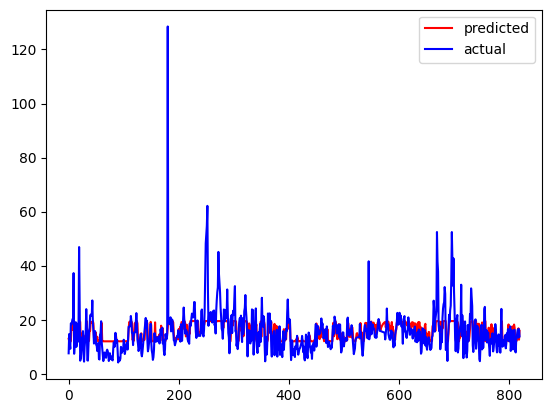

In [18]:
plot_predictions(model, X, y)

26/26 [==============================] - 0s 966us/step


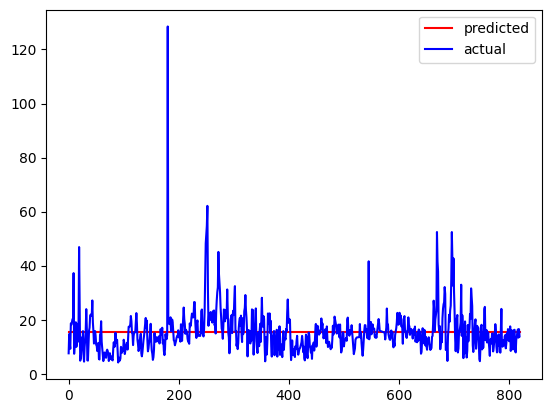

In [19]:
plot_predictions(model2, X, y)

26/26 [==============================] - 0s 904us/step


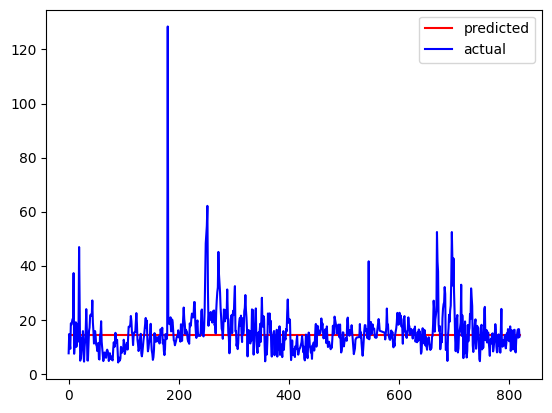

In [20]:
plot_predictions(model3, X, y)

### Adding scaling

In [21]:
def np_to_X_y(array, window_size=5):
    X=[]
    y=[]
    for i in range(len(array)-window_size):
        row = [r for r in array[i:i+window_size]]
        X.append(row)
        label = array[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0,1))

train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

window_size = 5
X_scaled, y_scaled = np_to_X_y(train_scaled, window_size)
valX_scaled, valy_scaled = np_to_X_y(test_scaled, window_size)

In [22]:
model4 = Sequential()
model4.add(LSTM(64, input_shape=(5,8)))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))
model4.compile(loss='mse', optimizer='adam')


In [23]:
history = model4.fit(X_scaled, y_scaled, epochs=50, validation_data=(valX_scaled, valy_scaled), verbose=2)

Epoch 1/50
26/26 - 1s - loss: 0.0040 - val_loss: 0.0044 - 1s/epoch - 48ms/step
Epoch 2/50
26/26 - 0s - loss: 0.0034 - val_loss: 0.0021 - 77ms/epoch - 3ms/step
Epoch 3/50
26/26 - 0s - loss: 0.0032 - val_loss: 0.0016 - 79ms/epoch - 3ms/step
Epoch 4/50
26/26 - 0s - loss: 0.0032 - val_loss: 0.0019 - 78ms/epoch - 3ms/step
Epoch 5/50
26/26 - 0s - loss: 0.0031 - val_loss: 0.0021 - 78ms/epoch - 3ms/step
Epoch 6/50
26/26 - 0s - loss: 0.0030 - val_loss: 0.0042 - 77ms/epoch - 3ms/step
Epoch 7/50
26/26 - 0s - loss: 0.0029 - val_loss: 0.0014 - 78ms/epoch - 3ms/step
Epoch 8/50
26/26 - 0s - loss: 0.0028 - val_loss: 0.0015 - 77ms/epoch - 3ms/step
Epoch 9/50
26/26 - 0s - loss: 0.0028 - val_loss: 0.0027 - 79ms/epoch - 3ms/step
Epoch 10/50
26/26 - 0s - loss: 0.0030 - val_loss: 0.0026 - 78ms/epoch - 3ms/step
Epoch 11/50
26/26 - 0s - loss: 0.0028 - val_loss: 0.0015 - 78ms/epoch - 3ms/step
Epoch 12/50
26/26 - 0s - loss: 0.0028 - val_loss: 0.0020 - 78ms/epoch - 3ms/step
Epoch 13/50
26/26 - 0s - loss: 0.0029 

26/26 [==============================] - 0s 965us/step


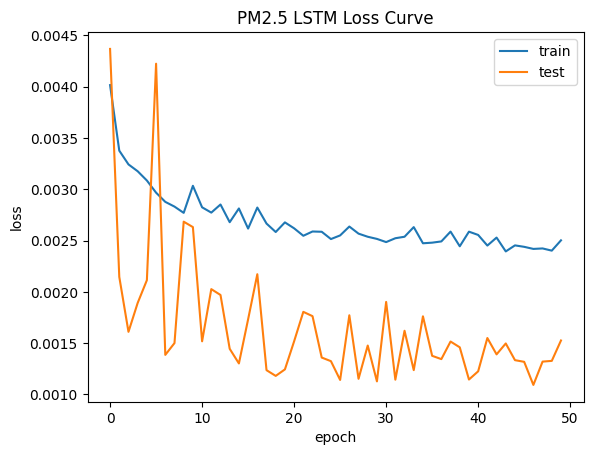

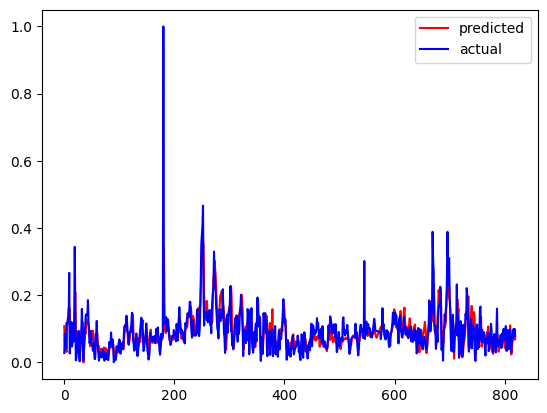

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("PM2.5 LSTM Loss Curve")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plot_predictions(model4, X_scaled, y_scaled)

In [25]:
from sklearn.metrics import mean_squared_error
#unscaling output
yhat = model4.predict(X_scaled)
for i in range(5):
    yhat = np.insert(yhat, 0, np.nan)
train_copy = train
train_copy.head()
train_copy['output'] = yhat
train_copy.drop('value', axis = 1, inplace = True)
train_copy = train_copy[['output','stp','wind_speed','max_sustained_wind','max_temp','min_temp','temperature','dewpoint']]
train_copy.head()

26/26 [==============================] - 0s 946us/step


C:\Users\Matthew\AppData\Local\Temp\ipykernel_218856\2283424937.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_copy['output'] = yhat
C:\Users\Matthew\AppData\Local\Temp\ipykernel_218856\2283424937.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_copy.drop('value', axis = 1, inplace = True)


,output,stp,wind_speed,max_sustained_wind,max_temp,min_temp,temperature,dewpoint
utc,,,,,,,,
2020-01-02,NaN,986.8,4.5,12.0,68.0,43.0,56.6,42.1
2020-01-03,NaN,994.0,1.6,6.0,73.0,45.0,56.7,39.3
2020-01-04,NaN,999.1,1.1,6.0,73.0,42.1,55.5,38.4
2020-01-05,NaN,998.0,2.8,11.1,73.0,42.1,54.7,36.3
2020-01-06,NaN,997.6,2.5,6.0,75.0,42.1,57.6,29.1


In [26]:
extracted_output = train_copy.to_numpy()
extracted_output = scaler.inverse_transform(extracted_output[5:])
extracted_output = [i[0] for i in extracted_output]

In [27]:
print(f'Mean squared error is {mean_squared_error(extracted_output, y)}')

Mean squared error is 37.64606436272319


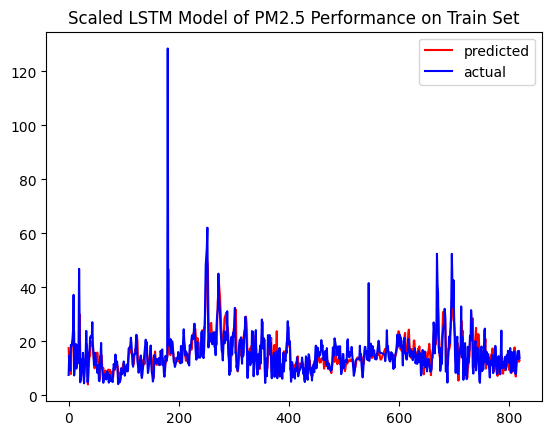

In [28]:
fig, ax = plt.subplots()
plt.title("Scaled LSTM Model of PM2.5 Performance on Train Set") 
plt.plot(extracted_output, color = 'red')
plt.plot(y, color = 'blue')
plt.legend(['predicted','actual'])
plt.show()

In [29]:
sum(y)/len(y)

15.361277401064006

7/7 [==============================] - 0s 1ms/step


C:\Users\Matthew\AppData\Local\Temp\ipykernel_218856\682039158.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_copy['output'] = yhat
C:\Users\Matthew\AppData\Local\Temp\ipykernel_218856\682039158.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_copy.drop('value', axis = 1, inplace = True)


Mean squared error is 23.588853320347038


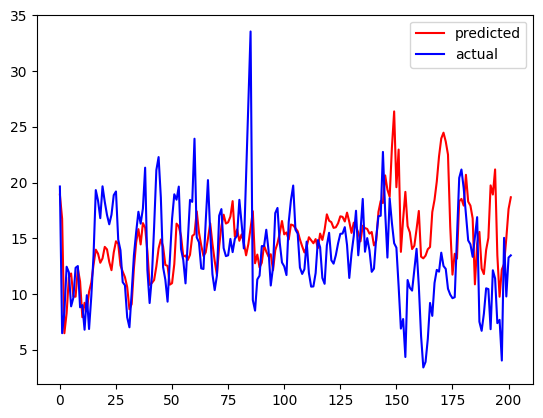

In [30]:
#unscaling output
yhat = model4.predict(valX_scaled)
for i in range(5):
    yhat = np.insert(yhat, 0, np.nan)
test_copy = test
test_copy['output'] = yhat
test_copy.drop('value', axis = 1, inplace = True)
test_copy = test_copy[['output','stp','wind_speed','max_sustained_wind','max_temp','min_temp','temperature','dewpoint']]

extracted_output = test_copy.to_numpy()
extracted_output = scaler.inverse_transform(extracted_output[5:])
extracted_output = [i[0] for i in extracted_output]

print(f'Mean squared error is {mean_squared_error(extracted_output, valy)}')
fig, ax = plt.subplots()
plt.plot(extracted_output, color = 'red')
plt.plot(valy, color = 'blue')
plt.legend(['predicted','actual'])
plt.show()

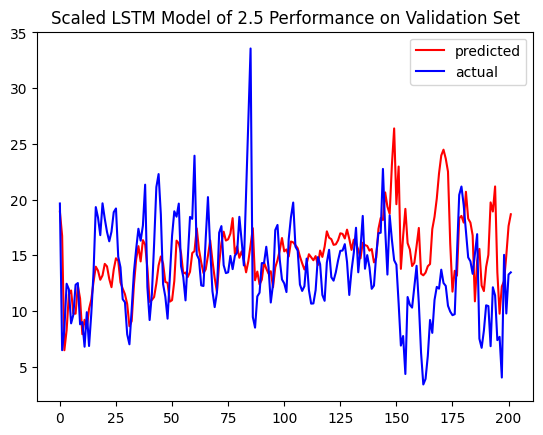

In [31]:
fig, ax = plt.subplots()
plt.title("Scaled LSTM Model of 2.5 Performance on Validation Set")
plt.plot(extracted_output, color = 'red')
plt.plot(valy, color = 'blue')
plt.legend(['predicted','actual'])
plt.show()